imports

In [ ]:
import cdshealpix
import healpy as hp
import numba
import numpy as np
import shapely
import sparse
import xarray as xr
from astropy.coordinates import Latitude, Longitude

In [ ]:
import matplotlib.pyplot as plt

load example dataset

In [ ]:
ds = (
    xr.tutorial.open_dataset("air_temperature", chunks={"time": 1})
    # .compute()
    # need to transform to 2D coords for now
    .pipe(
        lambda ds: ds.assign_coords(
            dict(zip(["longitude", "latitude"], xr.broadcast(ds.lon, ds.lat)))
        )
    )
    .swap_dims({"lon": "x", "lat": "y"})
    .drop_vars(["lon", "lat"])
)
ds

# interpolation

According to [^1], all interpolation methods can be written as a linear combination of field values and interpolation weights. Thus, we want to compute a sparse matrix of weights that can be applied to any array using sparse matrix multiplication. With that, the expensive part is the computation of the grid weights, which are computed once and only depend on the geometry of the source and target grids.

[^1]: Pletzer, Alexander & Hayek, Wolfgang. (2018). Mimetic Interpolation of Vector Fields on Arakawa C/D Grids. Monthly Weather Review. 147. 10.1175/MWR-D-18-0146.1. 

## bilinear interpolation

According to [^1], the bilinear interpolation can be visualized as dividing the rectangle of the surrounding source pixels into four (typically not equally sized) rectangles where the intersection of the inner borders is the target pixel. Then, the weights for a source pixel is the ratio between the area opposite of the source pixel to the area between all the source pixels.

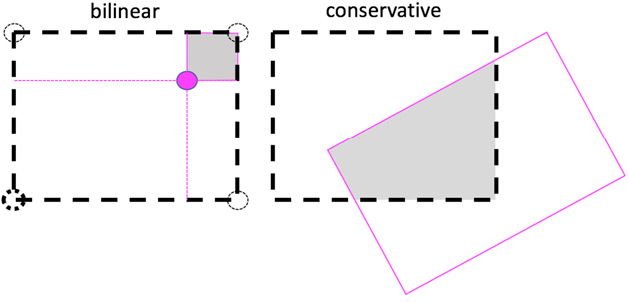

For the implementation of the interpolation, we thus need to:
1. determine the target pixels:
    1. compute bounding box of source pixels (on the sphere, or segmentize the bounding box to avoid great circle distances changing the grid too much)
    2. perform polygon search to find the target pixels
2. get the source coordinates of the target pixels ($P_i$)
3. find the 4 surrounding source cells for all target pixels
    1. create a tree with an appropriate metric
    2. find the 4 surrounding neighbors and their indices in the matrix
4. order the neighbors
    1. take the closest neighbor and call it A
    2. take the second closest neighbor and call it B
    3. find the third closest neighbor and call it C, such that AB is not (close to) parallel to AC
    4. find the neighbor that is about $\sqrt{|AB|^2 + |AC|^2}$ from A and completes the rectangle, and call it D
5. use vector algebra to determine the sides of the small and big rectangles:
    1. the small distance along AB: $s_1 = \frac{AB \circ AP}{|AB|}$
    2. the small distance along AC: $s_2 = \frac{AC \circ AP}{|AC|}$
    3. the big distance along AB: $s_3 = |AB| - s_1$
    4. the big distance along AC: $s_4 = |AC| - s_2$
6. compute the weights according to the schema in the picture:
    1.  $w_A = \frac{s_3 \cdot s_4}{a}$
    2.  $w_B = \frac{s_2 \cdot s_3}{a}$
    3.  $w_C = \frac{s_1 \cdot s_4}{a}$
    4.  $w_D = \frac{s_1 \cdot s_2}{a}$
6. compute the weights according to the schema above
    1. use spherical geometry to compute orthogonal distances of the target pixel to the rectangle sides
    2. apply the formula
    3. result: interpolation weights
7. construct the sparse matrix from the pixel indices from 3 and the interpolation weights from 6

Notes:
- The bounding box only works in the plane, on a sphere this fails because the sides are assumed to follow great circles. To avoid that, we can segmentize the bounding box using the target resolution
- for a rotated healpix grid we'd have to apply the rotation before any interaction with the grid, and transform back after we're done
- The neighbors search is not as simple as requesting the four closest neighbors, as especially the diagonals might be further from the point than vertices from a neighboring cell. To fix that in general, we'd have to use graph theory or use a RTree with cell polygons. However, under the assumption that the cell spacing in x is less than a factor of 2 from the cell spacing in y, we can retrieve the $k=6$ closest neighbors and do the neighbor ordering from 4
- The formulas in the algorithm are for a euclidean metric, which assumes 2D coordinates on a rectilinear grid. For curvilinear grids or spherical coordinates the general algorithm should still work, but the formulas (and the way the surrounding cells are found) might have to be changed.

### choose grid parameters

In this case we'll use a non-rotated healpix system as an example (no rotation as that makes the algorithm simpler).

We'll also use `depth` as the grid parameter instead of `nside`, but changing between them is easy: $d = \log_4{n_{side}}$ ↔ $n_{side} = 4^d$

In [ ]:
depth = 10

### grid definition: determine target pixels

The target pixels in general can be determined by computing the outline polygon of the source pixels and using healpix functions to find the target pixel indices at a given depth. In a flat coordinate system this is where a bounding box would be used, but to avoid great circle distances on the north / southern edge we need to segmentize the resulting polygon on a sphere. We'll also drop all cells that are not fully covered by the polygon to avoid having to decide on a boundary treatment.

In case we wanted a rotated healpix grid, we need to adjust the outline coordinates before performing the polygon search.

In [ ]:
bbox = shapely.box(
    ds.longitude.min().item(),
    ds.latitude.min().item(),
    ds.longitude.max().item(),
    ds.latitude.max().item(),
)
# todo: choose segment length according to grid spacing
outline = shapely.segmentize(bbox, max_segment_length=0.5)
outline_coords = shapely.get_coordinates(outline)
outline_coords

In [ ]:
pixel_indices_, _, fully_covered = cdshealpix.nested.polygon_search(
    Longitude(outline_coords[:, 0], unit="deg"),
    Latitude(outline_coords[:, 1], unit="deg"),
    depth=depth,
    flat=True,
)
pixel_indices = pixel_indices_[fully_covered.astype(bool)]
pixel_indices

plotting the result

### define source and target coordinates in the same system

To be able to perform the bilinear interpolation, we need 1D coordinates in the same grid system. We'll thus translate healpix pixel ids to lat / lon and stack the source coordinates.

In [ ]:
target_lon, target_lat = map(
    lambda x: np.asarray(np.rad2deg(x)),
    cdshealpix.nested.healpix_to_lonlat(pixel_indices, depth=depth),
)
target_lon, target_lat

In [ ]:
stacked = ds.stack(source_cells=["x", "y"])
source_lon = stacked["longitude"].data
source_lat = stacked["latitude"].data

### search the nearest neighbors

The next step is to do a nearest neighbors search for the 4 surrounding neighbors (the vertices).

Finding neighbors can be done very efficiently using a k-d tree or ball tree with an appropriate metric. `sklearn`'s tree implementations allow choosing the haversine distance metric, which makes calculations more accurate on a sphere.

However, while we can get the 4 closest points, it is not guaranteed that these form the surrounding rectangle. Since we already removed all cells that would need extrapolation, all that's left is to deal with cases where the target point is close to one of the vertices, which means that especially the diagonally opposite vertex might be further away than the vertex of a neighboring rectangle. To work around this, we might either use a more sophisticated search algorithm (e.g. a polygon search using a RTree or using graph theory), or we retrieve a bigger number of neighbors. With 6 neighbors

The trouble with this  is that in case the target point is close to one of the vertices (still within the source grid cell), it may be possible that a vertex on one of the coordinate axes is closer than the original. This means that the 4 nearest neighbors might form a symmetric triangle.

We can work around this by retrieving more nearest neighbors, where the first two are always A and B. As long as the grid spacing (coordinate values) of both coordinate axes is close, C will be the third neighbor and we can find D by taking the neighbor with the shortest distance to B.

We simply need to take care to also return the coordinates for the sparse array.

In [ ]:
from sklearn.metrics.pairwise import haversine_distances
from sklearn.neighbors import BallTree

In [ ]:
# the tree implementation expects n×m arrays, where m is the number of dimensions
source_coords = np.stack([source_lon, source_lat], axis=-1)
target_coords = np.stack([target_lon, target_lat], axis=-1)

In [ ]:
%%time
tree = BallTree(source_coords, metric="euclidean")
# five instead of four neighbors to make sure we include the diagonal
_, neighbor_indices = tree.query(target_coords, k=6)

### compute weights

For bilinear interpolation in cartesian coordinates, the principle is vector geometry:
1. take the vertex with the shortest distance to the interpolation point P and call it A
2. take the second-closest vertex and call it B
3. construct the vectors from A to the other 5 vertices
4. compute the dot product AB and the other vectors
5. take the point with the shortest distance to P that not parallel to AB and call it C
6. construct BC
7. compute the point half-way between B and C and call it M
8. compute the distance of all neighbors to M
9. take the point with the minimum distance to M that is not already found and call it D
10. construct the vector between A and P
11. compute the orthogonal distances from A to P using the dot product:
    - $s_1 = \frac{AB \circ AP}{|AB|}$
    - $s_2 = \frac{AC \circ AP}{|AC|}$
12. compute the other two distances using simple differences
    - $s_3 = AB - s_1$
    - $s_4 = AC - s_2$
13. compute the four small areas (could multiply by the cross product of the side vectors, but will divide afterwards anyways)
    - $A_1 = s_1 \cdot s_2$
    - $A_2 = s_2 \cdot s_3$
    - $A_3 = s_1 \cdot s_4$
    - $A_4 = s_3 \cdot s_4$
14. compute the big area: $A = |AB| \cdot |AC|$ (same here: multiply with cross product, but will result in the same ratio)
15. compute the weights as area ratios
    - $w_A = \frac{A_4}{A}$
    - $w_B = \frac{A_3}{A}$
    - $w_C = \frac{A_2}{A}$
    - $w_D = \frac{A_1}{A}$

Note that with this we have to keep track of the interpolation indices.

In [ ]:
@numba.njit
def norm(vectors, axis=-1):
    # todo: figure out if `np.linalg.norm` could be used instead
    return np.sqrt(np.sum(vectors**2, axis=axis))


@numba.njit
def _compute_bilinear_interpolation_weights(
    target_coords, source_coords, neighbor_indices
):
    # todo: use `guvectorize` instead of `njit` and the manual loop, as that would allow parallelizing the loop
    n_points = target_coords.shape[0]
    weights = np.zeros((n_points, 4), dtype=source_coords.dtype)
    cell_indices = np.zeros((n_points, 4), dtype=neighbor_indices.dtype)
    for index in range(n_points):
        # unpack
        P = target_coords[index, :]
        current_indices = neighbor_indices[index, :]
        neighbors = source_coords[current_indices, :]

        # create local index array
        cell_vertex_indices = np.zeros(4, dtype="int64")

        # A is always the closest neighbor
        index_A = 0
        cell_vertex_indices[0] = index_A
        A = neighbors[index_A, :]

        # B is always the second-closest neighbor
        index_B = 1
        cell_vertex_indices[1] = index_B
        B = neighbors[index_B, :]

        # determine C
        edges = neighbors - A
        edge_lengths = norm(edges)

        AB = edges[index_B, :] / edge_lengths[index_B]

        dot_product = edges @ AB / edge_lengths
        non_parallel_edge_indices = np.argwhere(np.abs(dot_product) < 0.99)

        index_C = non_parallel_edge_indices[0].item()
        cell_vertex_indices[2] = index_C
        C = neighbors[index_C, :]

        # determine D
        BC = C - B

        mid_point = B + BC / 2
        distances_mid = norm(neighbors - mid_point)
        distances_mid[cell_vertex_indices[:3]] = np.inf  # mask the already taken points

        index_D = np.argmin(distances_mid)
        cell_vertex_indices[3] = index_D

        # construct vectors
        AP = P - A
        AB = edges[index_B, :]
        AC = edges[index_C, :]

        # compute vector lengths
        lAB = edge_lengths[index_B]
        lAC = edge_lengths[index_C]

        # compute orthogonal distances
        s1 = abs(AB @ AP) / lAB
        s2 = abs(AC @ AP) / lAC

        s3 = lAB - s1
        s4 = lAC - s2

        # compute areas
        full_area = lAB * lAC
        # s1*s2 → D
        # s2*s3 → C
        # s1*s4 → B
        # s3*s4 → A
        small_areas = np.array([s3 * s4, s1 * s4, s2 * s3, s1 * s2])

        # weights
        current_weights = small_areas / full_area

        weights[index, :] = current_weights
        cell_indices[index, :] = current_indices[cell_vertex_indices]

    return weights, cell_indices

In [ ]:
%%time
weights, surrounding_vertex_indices = _compute_bilinear_interpolation_weights(
    target_coords[:20, ...], source_coords.astype("float64"), neighbor_indices[:20, ...]
)
display(weights, np.sum(weights, axis=1))

In [ ]:
%%time
weights, surrounding_vertex_indices = _compute_bilinear_interpolation_weights(
    target_coords, source_coords.astype("float64"), neighbor_indices
)
display(weights, np.sum(weights, axis=1))

In [ ]:
np.testing.assert_allclose(np.sum(weights, axis=1), 1)

### construct interpolation matrix

With the computed weights, we can construct the sparse matrix from a coordinate representation. In this case, the first dimension contains the number of target pixels, while the other dimensions follow the input grid.

In [ ]:
n_healpix = pixel_indices.size
n_source = source_coords.shape[0]
coords = np.stack(
    [
        np.broadcast_to(
            np.arange(n_healpix)[:, None], surrounding_vertex_indices.shape
        ),
        surrounding_vertex_indices,
    ],
    axis=0,
)
coords.shape

In [ ]:
%%time
source_shape = (ds.sizes[dim] for dim in ["x", "y"])
weights_matrix = sparse.COO(
    np.reshape(coords, (2, -1)),
    data=np.reshape(weights, -1),
    shape=(n_healpix, n_source),
).reshape((-1, *source_shape))
weights_matrix

In [ ]:
weights_arr = xr.DataArray(
    weights_matrix,
    dims=("cells", "x", "y"),
    coords={
        "longitude": ds["longitude"],
        "latitude": ds["latitude"],
        "cells": ("cells", pixel_indices, {"depth": depth, "grid_type": "healpix"}),
    },
)
weights_arr

### apply interpolation

With the interpolation matrix we can use `xr.dot` to very quickly do the interpolation:

In [ ]:
%%time
interpolated = ds.map(
    lambda arr: xr.dot(weights_arr.chunk(), arr, dims=("x", "y"))
).assign_coords({"latitude": ("cells", target_lat), "longitude": ("cells", target_lon)})
interpolated

### plot

In [ ]:
ds.air.isel(time=0).plot(x="longitude", y="latitude", cmap="viridis")

In [ ]:
plt.scatter(
    x=interpolated.longitude.data,
    y=interpolated.latitude.data,
    c=interpolated.air.isel(time=0, drop=True),
    s=5,
)

interactive plots with hvplot

In [ ]:
import hvplot.pandas
import hvplot.xarray

In [ ]:
p1 = (
    interpolated.air.isel(time=0, drop=True)
    .reset_coords()
    .to_pandas()
    .hvplot.points(
        x="longitude",
        y="latitude",
        c="air",
        cmap="viridis",
        geo=True,
        coastline="10m",
        rasterize=True,
    )
)
p2 = (
    ds.air.isel(time=0, drop=True)
    .compute()
    .hvplot.quadmesh(
        x="longitude",
        y="latitude",
        cmap="viridis",
        geo=True,
        coastline="10m",
        rasterize=True,
    )
)

p1 + p2